# Eigenfaces

In this notebook we explore how dimentionality reduction works, using eigenfaces as an example.

To use a notebook, click inside one of the boxes with code in it, and press "Run".

In [57]:
import numpy as np
from os import getcwd, path
import ImageUtils
%matplotlib inline

## Importing the pictures.

Take a lot of photos of yourself using your webcam of whatever. As they say, "the more the merrier". Try to make sure that only your face is in the photos. Put them in the folder printed below:

In [58]:
print(path.join(getcwd(), 'data'))

C:\Users\Christopher\Desktop\Projects\AI\Eigenfaces\data


The code below will load pictures from the `data` folder into the variable `X`. _(In machine learning, `X` is usually used to denote our inputs._)

X has shape (57, 128, 128)
Each image is a matrix of size (128, 128)


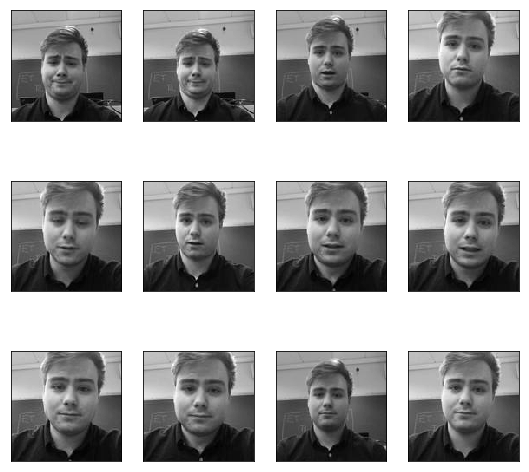

In [59]:
X, labels = ImageUtils.read_images("data")
X = np.array([np.array(image) for image in X])
X = ImageUtils.numpy_grayscale(X)

print("X has shape", X.shape)
print("Each image is a matrix of size", X.shape[1:])
ImageUtils.plot_gallery(X, None)

## PCA

As we now know the pca is all about finding the directions where the data varies the most. After we have obtained these directions we can start to use them for all sort of things.

![](images/pca.png)

In this image we can se the two principal components in a datasett. The first principal component is the longest line (green). This is the direction that explains the most of the variance of the data. The second component is the shorter dashed line.

### The algorithm

To actualy find the components is fairly easy if we close our eyes a bit when it comes to the math. We only have 4 simple steps. 

1. Subtract the mean. The "average image" has to be calculated and then subtracted from each original photo.
2. Perform Singular Value Decomposition. We need S and V. Use [`np.linalg.svd`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html). *Note: computation is MUCH faster if you set `full_matrices=False`*
3. Calculate explained variance for each principal component. For PCA, smart people have proved that: (singular value)² = eigenvalue = variance
4. Throw away everything except the first `n_components` vectors.

In [60]:
def pca_fit(X, n_components, n_samples):
    # Step 1: Calculate the mean, and subtract it from X
    mean = np.mean(X, axis=0)
    X_difference = X - mean

    # Step 2: Perform Singular Value Decomposition using np's linalg package.
    U, S, V = np.linalg.svd(X_difference, full_matrices=False)
    # U is the left singular vectors. We don't need them
    # S a vector containing the singular values (most books talk about this as a diagonal matrix)
    # V is the right singular vectors. It contains all principal components, sorted by how well they "capture" the data

    # Step 3 (Optional): Calculate explained variance.
    explained_variance = S**2

    # Step 4: We want n components, so throw away the other ones
    principal_components = V[:n_components]
    explained_variance = explained_variance[:n_components:]

    return principal_components, mean, explained_variance

One slight problem when dealing with images is that each image is, in itself, a matrix. But PCA doesn't work if you give it a list of matrices. So work around that, we "unroll" each image matrix into a vector, and place all the vectors into a large matrix.

*Note: `n_components` must be smaller than the number of photos you have.*

In [61]:
n_components = 10
n_samples = X.shape[0]

X_flat = np.reshape(X, (n_samples, 128*128))

principal_components, mean, explained_variance = pca_fit(X_flat, n_components, n_samples)

print("Principal component matrix has size", principal_components.shape)

Principal component matrix has size (10, 16384)


Our principal components are essentially vectors describing how to project the images down to our lower-dimensional vector space. This means they can show us what parts of the images are "most important".

Let's try to plot them! But they're a 10x16384-dimensional matrix, so we need to use reshape again to turn them back into a list of images with size 128x128.

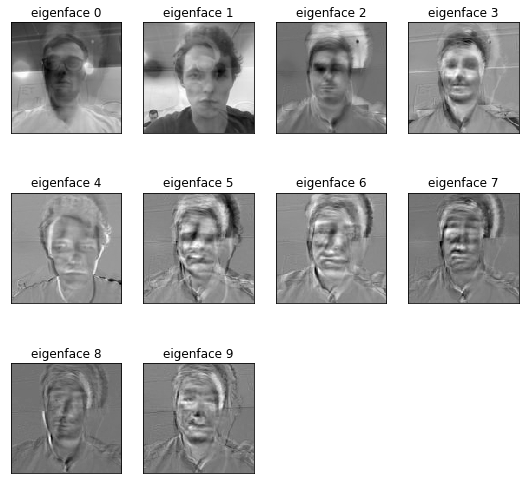

In [62]:
eigenfaces = principal_components.reshape((n_components,128,128))

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
ImageUtils.plot_gallery(eigenfaces, eigenface_titles)

If everything went well, you should see some slightly creepy-looking faces above. The more images you have, the more blurry and "ghost-like" they look.

But what are we looking at? The brightest pixels are the most different ones across the photos, and the darkest ones don't really matter.

You can also see that the first eigenfaces are the most blurry ones, while the last ones are fairly sharp. This is because we have few photos, and only a few photos have differences that haven't been captured by the earlier components. Therefore, the last few principal components simply look at the difference between those few photos.

For statistics geeks: if you print the `explained_variance` array, you might (depending on your photos) see that the amount variance explained by each vector decreases as the individual photos start shining through.

## Now what?

Add some photos of someone else, and run the code again. Can you tell from the eigenfaces what the computer uses to differentiate between you can your friend?


# Bonus! Use eigenfaces for face recognition

So far we have used an *un*supervised learning method to teach the computer how to find differences in our photos. But it doesn't have a clue what it's looking at. Let's try to teach it who is who. For this to work, we need at least 30 photos.

To do so, we have to give the computer an "answer sheet" for some of the photos (this is called **supervised learning**).

Write the name of the person in the photo at the beginning of every file name followed by an underscore, like this: `name_whatever.jpg`

*Example: `simen_imgw4etewf243t34f.jpg`*

Then, run the code below.

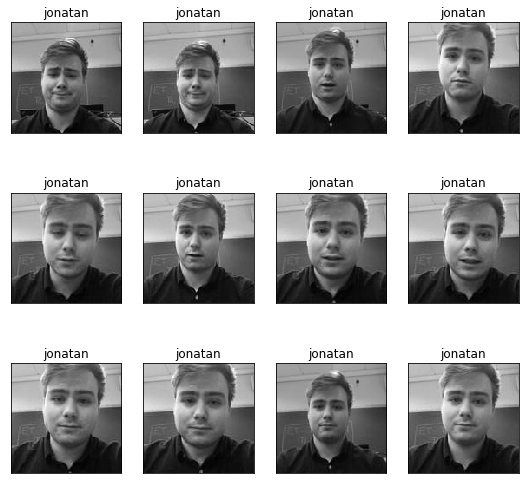

In [63]:
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


def prepare_labels(y):
    dummy = pd.get_dummies(y)
    return dummy.values.argmax(1), list(dummy)


def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)


# Load the images again, to include the answer sheet
X, labels = ImageUtils.read_images("data/")
X = np.array([np.array(image) for image in X])
X = ImageUtils.numpy_grayscale(X)
y = np.array(labels)
y, values = prepare_labels(y)

ImageUtils.plot_gallery(X, labels)  # Plot some photos to see that everything works

In the next block, there's a lot of stuff going on. There's also some terminology:
* classes = "number of possible answers"
* X or samples = the photos
* y or labels = the answer sheet
* training set = the samples and answer sheet we give to the computer, so it can learn what photo corresponds to which name
* test set = the samples we DON'T give the computer right away. Instead, we same them for later and give it only the photos to see if it can figure out the answers

In [64]:
n_classes = len(values)  # `values` contain all the possible answers
print("You have", n_classes, "different categories:", values)

# Set aside some photos so we can check if the computer actually learned anything.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print("Training set contains", len(X_train), "images, test set contains", len(X_test), "images")

You have 3 different categories: ['WIN', 'jonatan', 'omgN']
Training set contains 42 images, test set contains 15 images


## Projecting down to a lower dimension

Now, we need to project each photo down onto a lower dimension. Thanks to linear algebra, all we need to do is to calculate:

(X - mean) * principal_components^T

We also need to scale the values, to prevent bright pixels from taking over completely. We do that by dividing by the variance ("how much the data is spread out").

In [65]:
def pca_transform(X, principal_components, mean, explained_variance):
    # Step 1: Subtract the mean
    X_transformed = X - mean
    # Step 2: Project X down to low dimension
    X_transformed = np.dot(X_transformed, principal_components.T)
    # Step 3: Make sure the values are approximately the same size.
    X_transformed /= np.sqrt(explained_variance)
    return X_transformed

## Training

In [78]:
n_samples = X_train.shape[0]

# Unroll all the photos in X_train into a matrix, like before
X_train_flat = np.reshape(X_train,(X_train.shape[0], -1))


# Perform PCA. Notice we only pass in the training set
principal_components, mean, explained_variance = pca_fit(X_train_flat, n_components, n_samples)

# Project X down to our new vector space
X_train_pca = pca_transform(X_train_flat, principal_components, mean, explained_variance)


# Perform training
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}

clf = GridSearchCV(SVC(kernel="rbf", class_weight="balanced"), param_grid)
clf = clf.fit(X_train_pca, y_train)

print("Best estimator found by grid search:")
print(clf.best_estimator_)

Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


## Testing

The computer claims to have found something, but… did it really work? Let's use our test set (the photos we set aside earlier) to give the computer an "exam" to see if it actually is able to tell the faces apart.

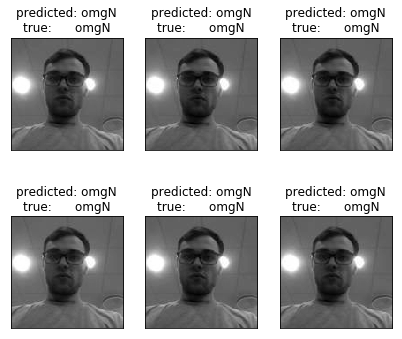

[[ 2  0  0]
 [ 0  3  0]
 [ 0  0 10]]


In [79]:
X_test_flat = np.reshape(X_test, (X_test.shape[0], -1))
X_test_pca = pca_transform(X_test_flat, principal_components, mean, explained_variance)
y_pred = clf.predict(X_test_pca)

prediction_titles = [title(y_pred, y_test, values, i)
                     for i in range(y_pred.shape[0])]
ImageUtils.plot_gallery(X_test, prediction_titles, 128, 128, 2, 3)

print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


That little matrix we got at the end there is called a *confusion matrix*. The top-left and bottom-right corners count how many correct predictions we got, while the other two corners count wrong answers.


C:\Users\Christopher\Desktop\Projects\AI\Eigenfaces\ku
X has shape (1, 128, 128)
Each image is a matrix of size (128, 128)


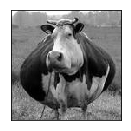

In [85]:
#Mappen du lager for bildene, tilsvarer "data" fra lengre opp. Min mappe heter "ku"
#Dette er for å få bildene på riktig format, og er en kopi av koden lengre opp
print(path.join(getcwd(), 'ku'))

X, labels = ImageUtils.read_images("ku")
X = np.array([np.array(image) for image in X])
X = ImageUtils.numpy_grayscale(X)


print("X has shape", X.shape)
print("Each image is a matrix of size", X.shape[1:])
ImageUtils.plot_gallery(X, None)

In [86]:
#Her reshaper vi bildet slik at vi kan sende det inn i algoritmen vår
#Bildet mitt heter "cow" og ligger i mappen "ku"
from PIL import Image
cow = np.array(Image.open("ku/ku2.jpg"))
gray_cow = ImageUtils.numpy_grayscale(cow)

flat_gray_cow = np.reshape(gray_cow, (1,128*128))

flat_cow_pca = pca_transform(flat_gray_cow, principal_components, mean, explained_variance)

#Her kjører vi bildet inn og får ut hvem datamaskinen tror det er
pred = clf.predict(flat_cow_pca)
#pred printer ut hvilket element i listen PCen tror bildet er
pred

ValueError: cannot reshape array of size 493075 into shape (1,16384)